### Entendimento dos Dados

In [1]:
# Importando as bibliotecas necessárias para esse projeto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pycaret
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from pycaret.classification import setup, create_model, predict_model, save_model

##### 1. Exploração primária
Para o entendimento geral, busquei criar gráficos de musicas populares e não populares, com as features mais básicas que imaginei impactar na predição de próximas musicas, 'energy', 'tempo' e 'danceability'. Com esses gráficos notei que havia uma diferença de padrões quando comparava popularidade dentro de uma mesma feature.

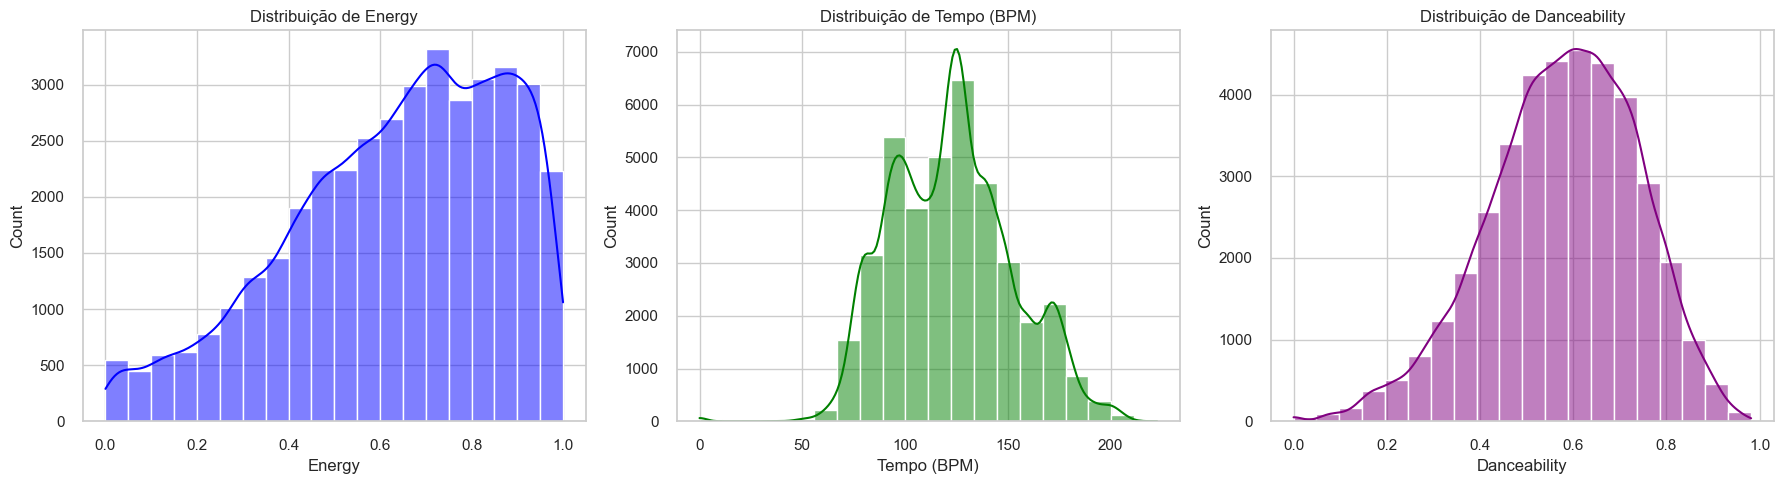

In [2]:
# Filtrando as músicas populares
df = pd.read_csv("train.csv/train.csv")
popular = df[df["popularity_target"] == 1]

# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Plotando gráficos de densidade para 'energy', 'tempo' e 'danceability'
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de densidade para 'energy'
sns.histplot(popular["energy"], kde=True, color="blue", bins=20, ax=axes[0])
axes[0].set_title('Distribuição de Energy')
axes[0].set_xlabel('Energy')

# Gráfico de densidade para 'tempo'
sns.histplot(popular["tempo"], kde=True, color="green", bins=20, ax=axes[1])
axes[1].set_title('Distribuição de Tempo (BPM)')
axes[1].set_xlabel('Tempo (BPM)')

# Gráfico de densidade para 'danceability'
sns.histplot(popular["danceability"], kde=True, color="purple", bins=20, ax=axes[2])
axes[2].set_title('Distribuição de Danceability')
axes[2].set_xlabel('Danceability')

plt.tight_layout()
plt.show()


Aqui, por exemplo, foi possivel identificar um padrão inicial, das 3 features, sem relacionar com a popularidade.

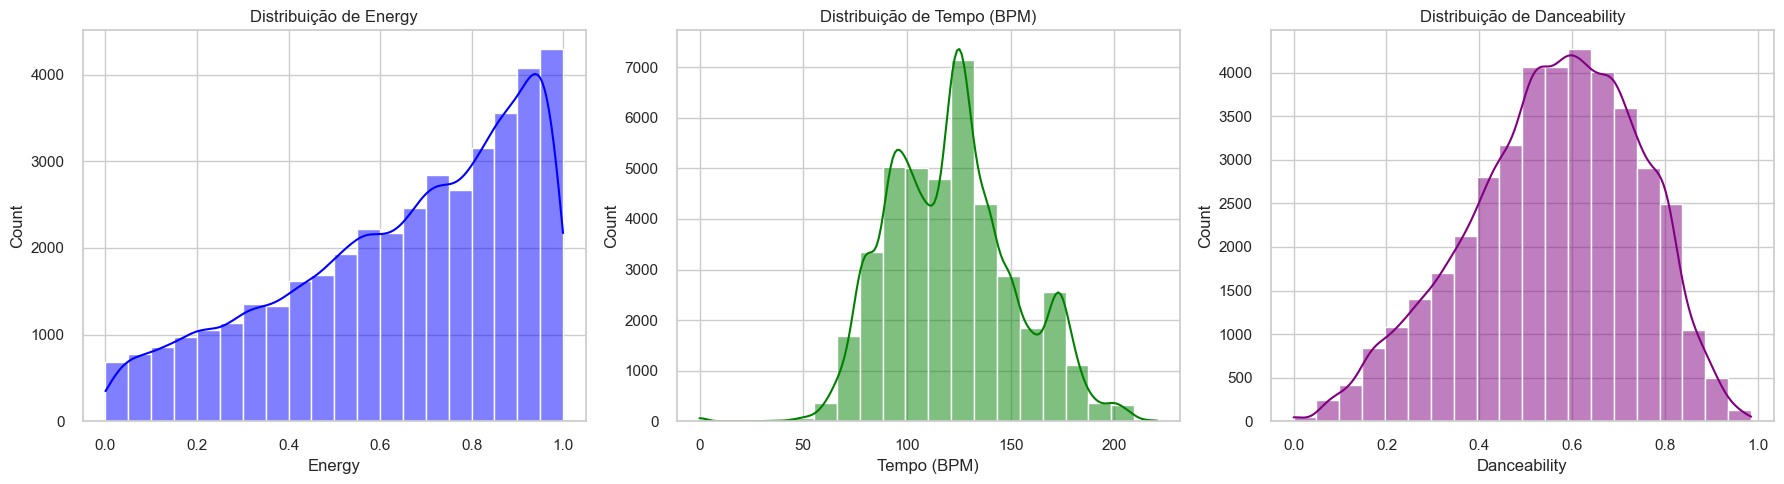

In [3]:
# Filtrando as músicas NÃO populares
df = pd.read_csv("train.csv/train.csv")
popular = df[df["popularity_target"] == 0]

# Configurando o estilo dos gráficos
sns.set(style="whitegrid")

# Plotando gráficos de densidade para 'energy', 'tempo' e 'danceability'
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de densidade para 'energy'
sns.histplot(popular["energy"], kde=True, color="blue", bins=20, ax=axes[0])
axes[0].set_title('Distribuição de Energy')
axes[0].set_xlabel('Energy')

# Gráfico de densidade para 'tempo'
sns.histplot(popular["tempo"], kde=True, color="green", bins=20, ax=axes[1])
axes[1].set_title('Distribuição de Tempo (BPM)')
axes[1].set_xlabel('Tempo (BPM)')

# Gráfico de densidade para 'danceability'
sns.histplot(popular["danceability"], kde=True, color="purple", bins=20, ax=axes[2])
axes[2].set_title('Distribuição de Danceability')
axes[2].set_xlabel('Danceability')

plt.tight_layout()
plt.show()

Agora, comos gráficos gerados anteriormente com esses novos gráficos, é possivel identificar algumas caracteristicas que poderiam estar associadas a popularidade das músicas, como por exemplo a nota máxima em "Energy". Pode-se verificar que dentro da classificação 1 de Energia da musica, há mais musicas impopulares (gráfico de baixo) do que populares (gráfico de cima)


##### 2. Exploração aprofundada das features

Para conseguir chegar em features mais importantes para o modelo em si, tomei como base os gráficos e análise feita anteriormente e aumentei a quantidade de features para analisar, explorando muito bem a tabela de features que nos foi fornecida. Nela, havia diversas features pouco uteis quanto outras muito importantes, dentre as que considerei uteis estão mostradas gráficamente a seguir, já com a comparação de popularidade:

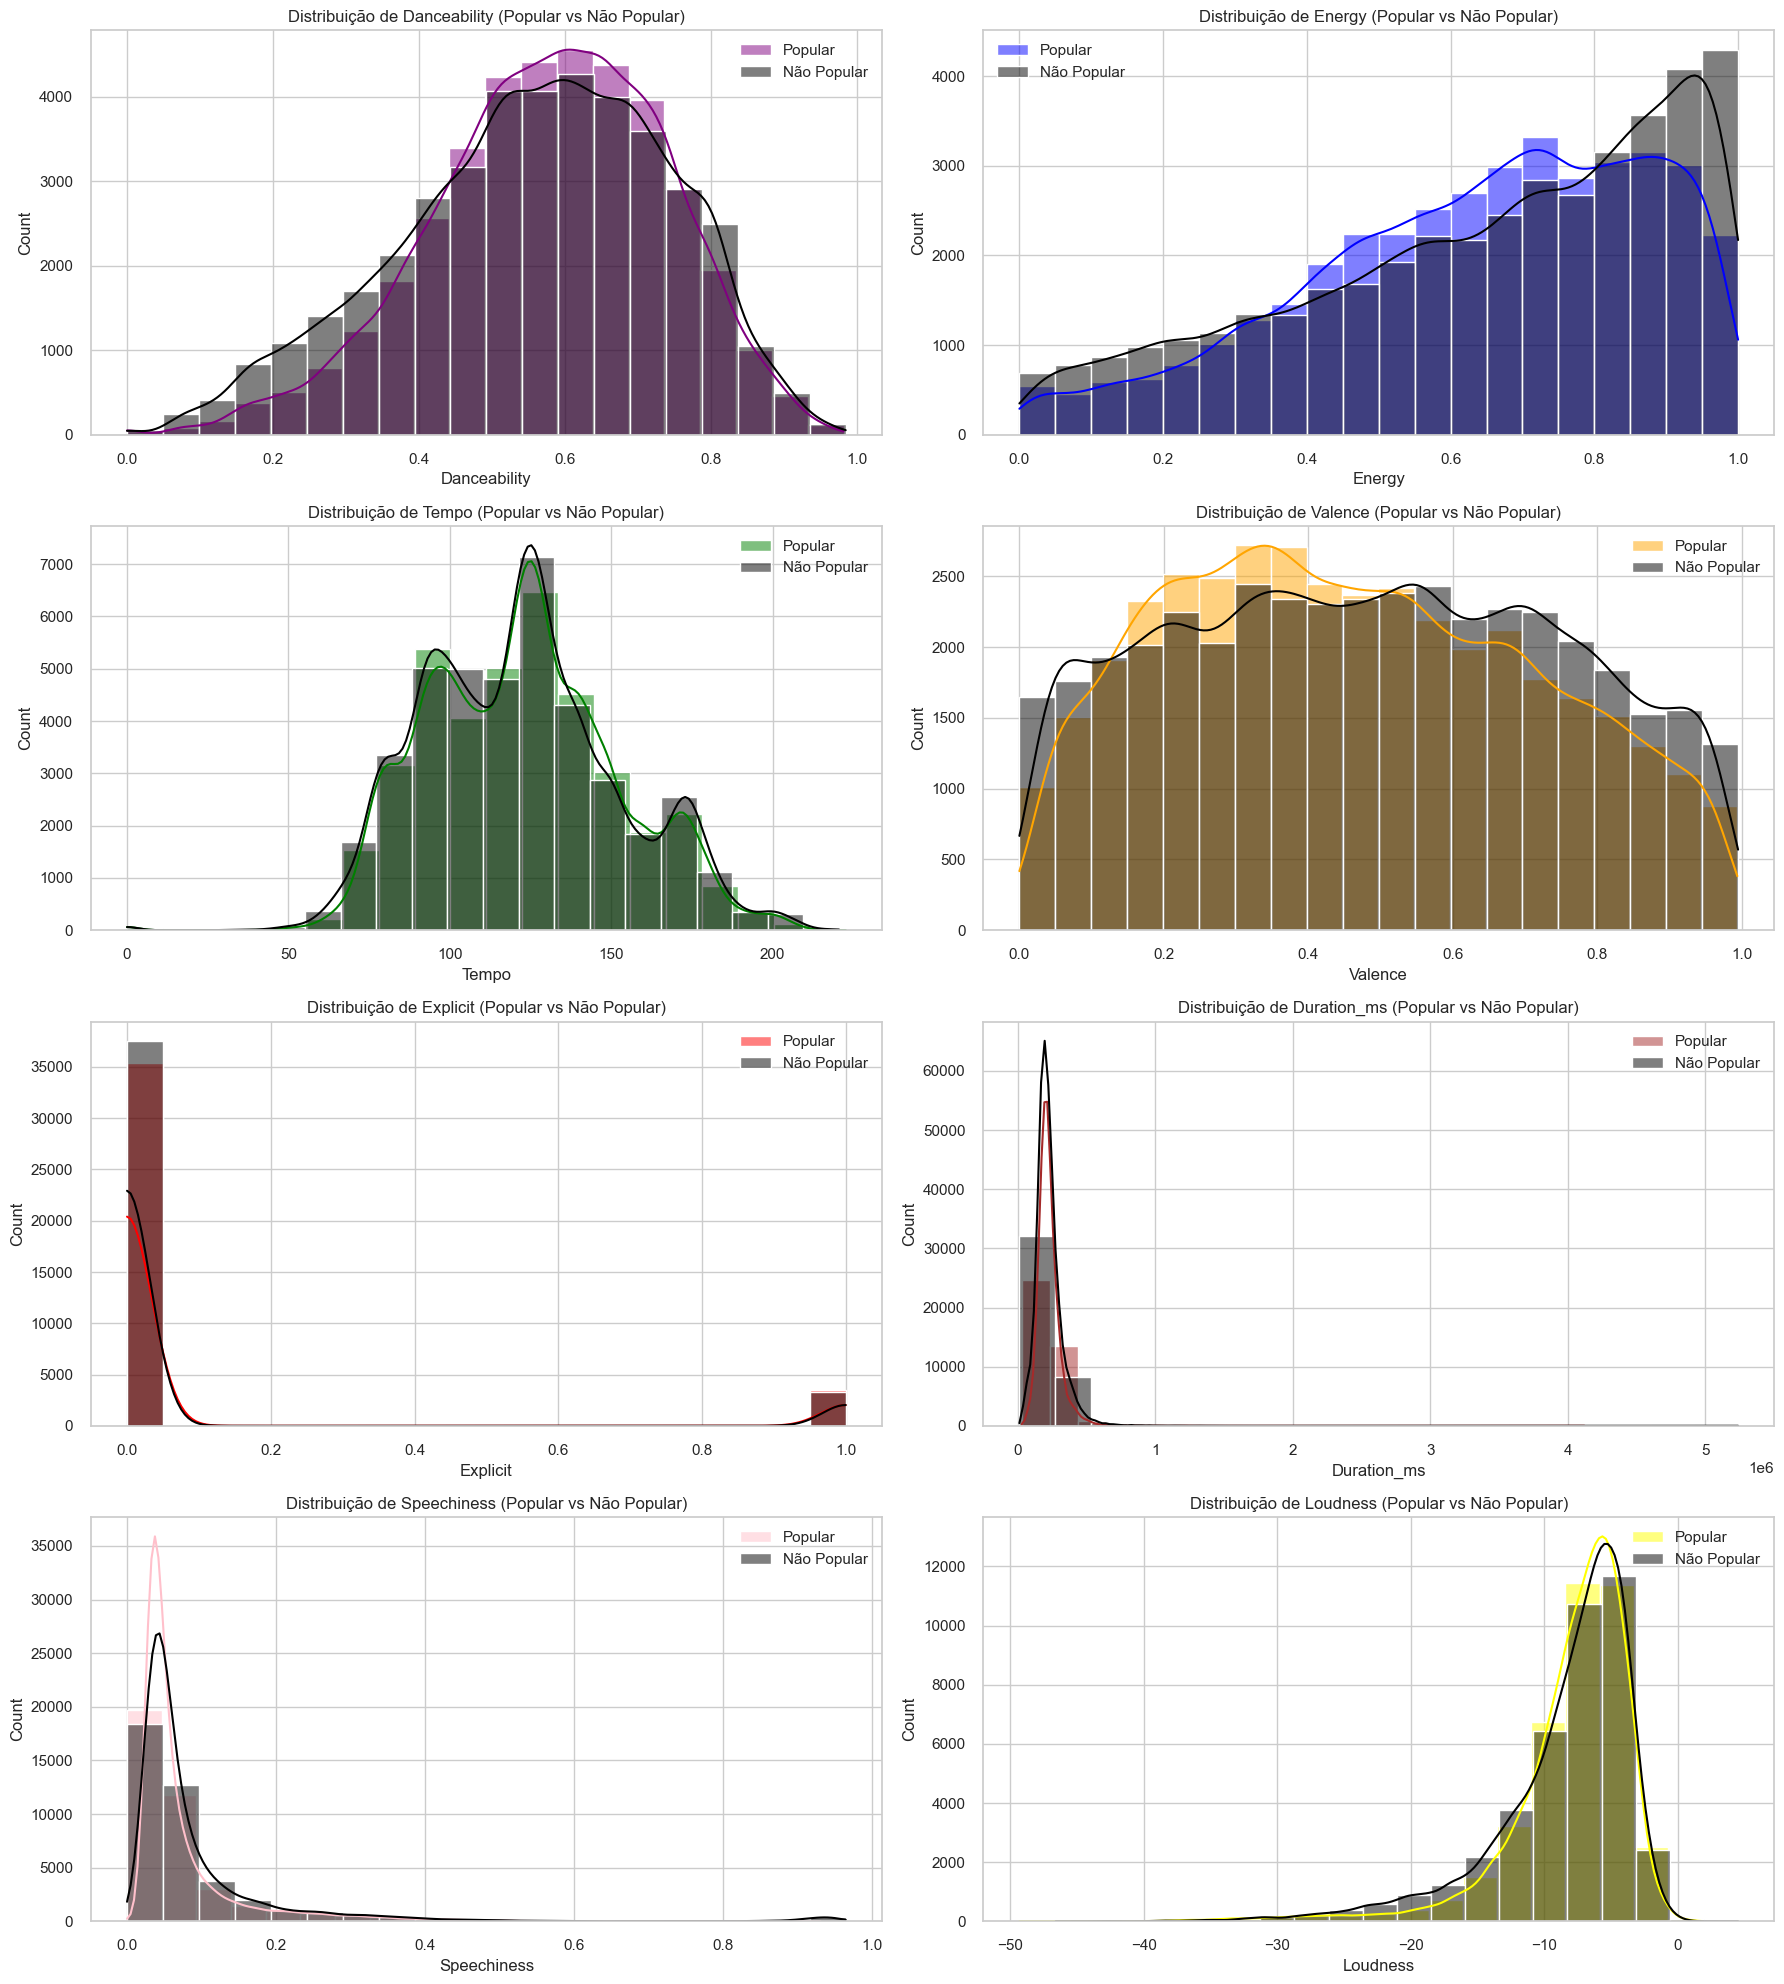

In [4]:
# Carregar novamente os dados do dataset
df = pd.read_csv("train.csv/train.csv")

# Filtrar as músicas populares e não populares
popular = df[df["popularity_target"] == 1]
naoPopular = df[df["popularity_target"] == 0]

# Configurar o estilo dos gráficos
sns.set(style="whitegrid")

# Criar uma figura com 4 linhas e 2 colunas para as 8 features
fig, axes = plt.subplots(4, 2, figsize=(18, 20))

# Lista de features para plotar
features = ['danceability', 'energy', 'tempo', 'valence', 'explicit', 'duration_ms', 'speechiness', 'loudness']
colors = ['purple', 'blue', 'green', 'orange', 'red', 'brown', 'pink', 'Yellow']

# Loop para gerar os gráficos de densidade para músicas populares e não populares
for i, feature in enumerate(features):
    # Plot para músicas populares
    sns.histplot(popular[feature], kde=True, color=colors[i], bins=20, label="Popular", ax=axes[i//2, i%2])
    
    # Plot para músicas não populares
    sns.histplot(naoPopular[feature], kde=True, color='black', bins=20, label="Não Popular", ax=axes[i//2, i%2], alpha=0.5)
    
    # Configurações dos gráficos
    axes[i//2, i%2].set_title(f'Distribuição de {feature.capitalize()} (Popular vs Não Popular)')
    axes[i//2, i%2].set_xlabel(feature.capitalize())
    
    # Mostrar a legenda para identificar as categorias
    axes[i//2, i%2].legend()

# Ajustar o layout para evitar sobreposição
plt.tight_layout()

# Mostrar o gráfico
plt.show()

Apartir de todos esses gráficos, é notável que grande parte das features selecionadas interferem diretamente na popularidade da musica, e, posteriormente será tambem contabilizado o peso de cada uma das features utilizada durante os modelos preditivos.

##### 3. Hipóteses

Dentro da análise feita, há algumas hipóteses de como os dados afetam a realidade de popularidade da musica:

- *Musicas com caracteristicas muito extremas podem ter maior dificuldade em tornarem-se populares*. Dentro da análise gráfica feita acima, "danceability", "energy" e "Valence" possuem maiores valores populares que impopulares quando essas features não são extremas, ou seja, estão no meio do gráfico. Isso pode significar que quando uma musica é muito forte em uma unica caracteristica pode restringir o publico que a ouve e, consequentemente, a popularidade dela.

- *Musicas explicitas não afetam muito a percepção da qualidade*. Ao analisár o gráfico da feature implicito, há pouca variação de popularidade nessa feature, em comparação aos outros, por isso, acredito que seja uma característica de menor influencia, visto que ouvir uma musica super legal e empolgante não necessariamente vai ser ofuscado pela forma explicita ou não do conteúdo. Tavlez mude só o público que o consome, mas vai consumir ainda pelas outras caracteristicas da musica.

- *Musicas alto astral tem uma chance maior de bombar*. Se avaliar os gráficos de danceabilidade e também de energia, estão no centro mas há uma tendencia a estarem para valores maiores, ou seja, possuirem uma inclinação a musicas mais felizes e energéticas. Essa tendencia pode ser racionalizada como musicas contagiantes, faceis de trazer bons sentimentos e lembrar de bons sentimentos ao escutalas, por isso, talvez, podemos verificar essas tendencias positivas nas musicas populares.

### Limpeza de Dados

##### 1. Limpeza geral

- Aqui, houve uma limpeza geral dos dados do df, primeiramente criando uma variável "features" apartir das features selecionadas: 'danceability', 'energy', 'tempo', 'valence', 'explicit', 'track_genre', 'duration_ms', 'speechiness', 'loudness'. Variável essa que será utilizada para treinar os modelos.
- Faço o imput desses dados em X que terá as informações e variáveis relevantes para os modelos, features essas que fazem maior sentido para a utilização em um modelo preditivo dessa finalidade. 
- Seleciono como Y a coluna alvo.
- Por fim, faço a converção de variáveis categóricas (ex.: track_genre, explicit) em numéricas para o modelo enteder bem.

In [49]:
# Selecionando as features relevantes
features = ['danceability', 'energy', 'tempo', 'valence', 'explicit', 'track_genre', 
                'duration_ms', 'speechiness', 'loudness']

# Filtrando apenas as colunas selecionadas
X = df[features]

# Target - 'popularity_target' será a variável alvo
y = df['popularity_target']

# Convertendo 'explicit' que é uma variável booleana para 0/1
df['explicit'] = df['explicit'].astype(int)

# Convertendo o gênero musical 'track_genre' para valores numéricos
label_encoder = LabelEncoder()
df['track_genre'] = label_encoder.fit_transform(df['track_genre'])

### Modelo Supervisionado DecisionTreeClassifier

O DecisionTree é um modelo relativamente simples que pode dar diversos resultados importantes para o entedimento da popularidade e do impacto das variáveis na aplicação do modelo. A seguir, é feito o teste desse modelo.

In [6]:
# Dividir os dados em conjunto de treino e teste (80% treino, 20% teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar e treinar o modelo de Árvore de Decisão
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = clf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo: {accuracy * 100:.2f}%")

# Exibir o relatório detalhado de métricas (Precisão, Recall, F1-Score)
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))

# Mostrar importância das features para a Árvore de Decisão
importances = clf.feature_importances_
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance:.4f}')

Acurácia do modelo: 74.44%
Relatório de classificação:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75      8247
           1       0.74      0.73      0.73      7713

    accuracy                           0.74     15960
   macro avg       0.74      0.74      0.74     15960
weighted avg       0.74      0.74      0.74     15960

danceability: 0.1016
energy: 0.0979
tempo: 0.0986
valence: 0.0989
explicit: 0.0081
track_genre: 0.2915
duration_ms: 0.1105
speechiness: 0.0942
loudness: 0.0986


##### Discussão dos resultados do modelo

Com a acurácia de 74%, é possivel identificar que houve uma escolha boa de features gerais, com uma qualidade aceitável na deteção de hits a partir dessas características. Tanto a precisão, quanto o recall (e por consequencia o f1-score que é a combincação de ambos) apresentaram valores próximos a 3/4 em sua nota, o que demonstra que o modelo ainda não efetua uma boa classificação.

Já vizualizando o impacto das features, vemos que uma das hipóteses formuladas, pode ser sustentada também pelo impacto baixo da feature "explicit" que tem um impacto signitivamente menor na tomada de decisões do modelo. Por outro lado, há a presença de muito forte da feature "track_genre" na predição, o que pode sustentar ideias de que o genero musical é uma fortissima caracteristica para o hit ou não de uma musica.

### Modelo Supervisionado RandomForestClassifier

Uma diferente perspectiva será adotada para vizualizar a performace dos modelos, o RandomForestClassifier foi escolhido pela similaridade com o modelo de decision tree em alguns aspectos com a capacidade de ser mais plural que o outro.

In [45]:
from sklearn.ensemble import RandomForestClassifier

# Criar e treinar o modelo de Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = rf_clf.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do modelo Random Forest: {accuracy * 100:.2f}%")

# Exibir o relatório detalhado de métricas (Precisão, Recall, F1-Score)
print("Relatório de classificação:")
print(classification_report(y_test, y_pred))

# Mostrar importância das features
importances = rf_clf.feature_importances_
for feature, importance in zip(features, importances):
    print(f'{feature}: {importance:.4f}')

ValueError: could not convert string to float: 'goth'

##### Discussão dos resultados do modelo

Com a acurácia de 80%, pode-se afirmar que a escolha do modelo interferiu signitivamente na performace de predição de novos hits, para além da própria escolha ideal das features. Tanto a precisão, quanto o recall (e por consequencia o f1-score que é a combincação de ambos) apresentaram valores próximos novamente a 80 em sua nota, o que é uma melhora em comparação ao modelo anterior, satisfazendo melhor o objetivo de identificação de hits.

Já vizualizando o impacto das features nesse modelo, podemos identificar o mesmo comportamento do modelo anterior em que o menor peso é a feature "explicit" e maior "track_genre" o que mostra convergência de respostas de ambos os modelos e consistencia de performace. Para além disso, as demais características são mais uniformes em peso que a arvore de decisões, talvez pela pluralidade de perspectivas que o random forest forneça essa uniformidade se mostra mais presente. 

### Comparação de modelos com Pycaret

Aqui, será utilziado a ferramente Pycaret para a facilitação de comparação de multiplos modelos de forma ágil e eficiente. Nesse bloco de código, é demandado a escolha do melhor modelo e a amostragem das métricas.

In [9]:
from pycaret.classification import setup, compare_models

# Configuração do PyCaret
clf_setup = setup(data=df,
                  target='popularity_target', 
                  numeric_features=['danceability', 'energy', 'tempo', 'valence', 'explicit', 'duration_ms', 
                                    'speechiness', 'loudness'],
                  categorical_features=['track_genre'])

# Comparar todos os modelos e selecionar o melhor
best_model = compare_models(sort='Accuracy', verbose=True)

,Description,Value
0,Session id,5814
1,Target,popularity_target
2,Target type,Binary
3,Original data shape,"(79800, 21)"
4,Transformed data shape,"(79800, 21)"
5,Transformed train set shape,"(55860, 21)"
6,Transformed test set shape,"(23940, 21)"
7,Numeric features,8
8,Categorical features,1
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8810,0.9479,0.8959,0.8651,0.8802,0.7620,0.7625,0.9540
dummy,Dummy Classifier,0.5122,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1760


Surpreedentemente o modelo alcançou a marca de 88% de acurácia, com ótias métricas resultantes, o que se mostra como um modelo satisfatório para o desafio demandado. O modelo dessa acurácia é o lightgbm (Light Gradient Boosting Machine).

Assim, o objetivo de prever os próximos hits do spotfy pode ser feito com uma qualidade boa e aceitável utilizando as features: ['danceability', 'energy', 'tempo', 'valence', 'explicit', 'duration_ms','speechiness', 'loudness'] e utilizando o modelo:  lightgbm (Light Gradient Boosting Machine).

### Considerações extras, sem utilizar a feature: "explicit"

In [11]:
from pycaret.classification import setup, compare_models

# Configuração do PyCaret
clf_setup = setup(data=df,
                  target='popularity_target', 
                  numeric_features=['danceability', 'energy', 'tempo', 'valence', 'duration_ms', 
                                    'speechiness', 'loudness'],
                  categorical_features=['track_genre'])

# Comparar todos os modelos e selecionar o melhor
best_model = compare_models(sort='Accuracy', verbose=True)

,Description,Value
0,Session id,8325
1,Target,popularity_target
2,Target type,Binary
3,Original data shape,"(79800, 21)"
4,Transformed data shape,"(79800, 21)"
5,Transformed train set shape,"(55860, 21)"
6,Transformed test set shape,"(23940, 21)"
7,Numeric features,7
8,Categorical features,1
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8770,0.9466,0.8911,0.8617,0.8761,0.7542,0.7546,2.6850
dummy,Dummy Classifier,0.5122,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2830


Considerações extras: O modelo sem utilizar a variável "Explicit" mesmo que menos impactante, apresenta uma acurácia menor, mesmo que pouco menor, o que pode reforçar o pouco impacto da variável na análise.

In [34]:
from pycaret.classification import predict_model, load_model
from sklearn.preprocessing import LabelEncoder

# Carregar o modelo LightGBM treinado
lgbm_model = load_model('lightgbm_model')

# Preparar os dados de teste
df_test = pd.read_csv("test.csv")

# Aplicar Label Encoding na coluna 'track_genre' (categórica)
label_encoder = LabelEncoder()
df_test['track_genre'] = label_encoder.fit_transform(df_test['track_genre'])

# Convertendo 'explicit', que é uma variável booleana, para 0/1
df_test['explicit'] = df_test['explicit'].astype(int)

# Remover as colunas desnecessárias
X_test_final = df_test.drop(['track_unique_id', 'track_id', 'track_name'], axis=1)

# Fazer previsões com o modelo LightGBM
predictions = predict_model(lgbm_model, data=X_test_final)

# Verificando o que está sendo retornado
print(predictions.columns)  # Verifique as colunas do DataFrame de previsões

# Criar o DataFrame final com as previsões
predicted_results = pd.DataFrame({
    'track_unique_id': df_test['track_unique_id'],  # Manter o ID da música
    'popularity_target': predictions['Label'] if 'Label' in predictions.columns else predictions.iloc[:, -1]  # Usar a coluna de previsões
})

# Arredondar as previsões para 0 ou 1
predicted_results['popularity_target'] = predicted_results['popularity_target'].round().astype(int)

# Salvar o arquivo CSV com as previsões
predicted_results.to_csv('resultados.csv', index=False)

print("Previsões salvas com sucesso no arquivo 'resultados.csv'")


Transformation Pipeline and Model Successfully Loaded


Index(['artists', 'album_name', 'duration_ms', 'explicit', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre', 'prediction_label', 'prediction_score'],
      dtype='object')
Previsões salvas com sucesso no arquivo 'resultados4.csv'


In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Separar features (X) e target (y)
X_train = df[['danceability', 'energy', 'tempo', 'valence', 'explicit', 'track_genre', 'duration_ms', 'speechiness', 'loudness']]
y_train = df['popularity_target']

# Convertendo 'explicit' que é uma variável booleana para 0/1
df['explicit'] = df['explicit'].astype(int)

# Convertendo o gênero musical 'track_genre' para valores numéricos
label_encoder = LabelEncoder()
df['track_genre'] = label_encoder.fit_transform(df['track_genre'])

# Treinar o modelo Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Preparar os dados de teste
df_test = pd.read_csv("test.csv")

# Aplicar Label Encoding na coluna 'track_genre' (categórica)
df_test['track_genre'] = label_encoder.fit_transform(df_test['track_genre'])

# Convertendo 'explicit' que é uma variável booleana para 0/1
df_test['explicit'] = df_test['explicit'].astype(int)

# Remover as colunas desnecessárias
X_test_final = df_test[['danceability', 'energy', 'tempo', 'valence', 'explicit', 'track_genre', 'duration_ms', 'speechiness', 'loudness']]

# Fazer previsões com o modelo Random Forest
predictions = rf_model.predict(X_test_final)

# Criar o DataFrame final com as previsões
predicted_results = pd.DataFrame({
    'track_unique_id': df_test['track_unique_id'],
    'popularity_target': predictions
})

# Salvar o arquivo CSV com as previsões
predicted_results.to_csv('resultados_rf.csv', index=False)

print("Previsões salvas com sucesso no arquivo 'resultados_rf.csv'")


Previsões salvas com sucesso no arquivo 'resultados_rf.csv'
